In this notebook, we will demonstrate how to use the FMM to do a gravitational simulation.

Recall that Newton's law's of motion according to a mathematician, i.e., devoid of any physical constants is given by

$$
\boldsymbol{x}_{j}''(t) = -\sum_{\substack{k=1\\k\neq j}}^{N} \frac{m_{k} (\boldsymbol{x}_{j}-\boldsymbol{x}_{k})}{|\boldsymbol{x}_{j}-\boldsymbol{x}_{k}|^3}
$$

Note that the forces are exactly the sums the FMM is designed to compute fast.

However, before scaling up to big problems, always a good idea to check things we know about the problem. For example, if we start in flat land, i.e. planets in a plane, and there is a massive sun, i.e. $m_{1} \gg m_{j}$ for all $j>1$, and the initial velocity are set as $\sqrt{m_{1}/|x_{j}|} x_{j}^{\perp}$, then the planets will orbit the sun. Let's try this out.

<IPython.core.display.Javascript object>


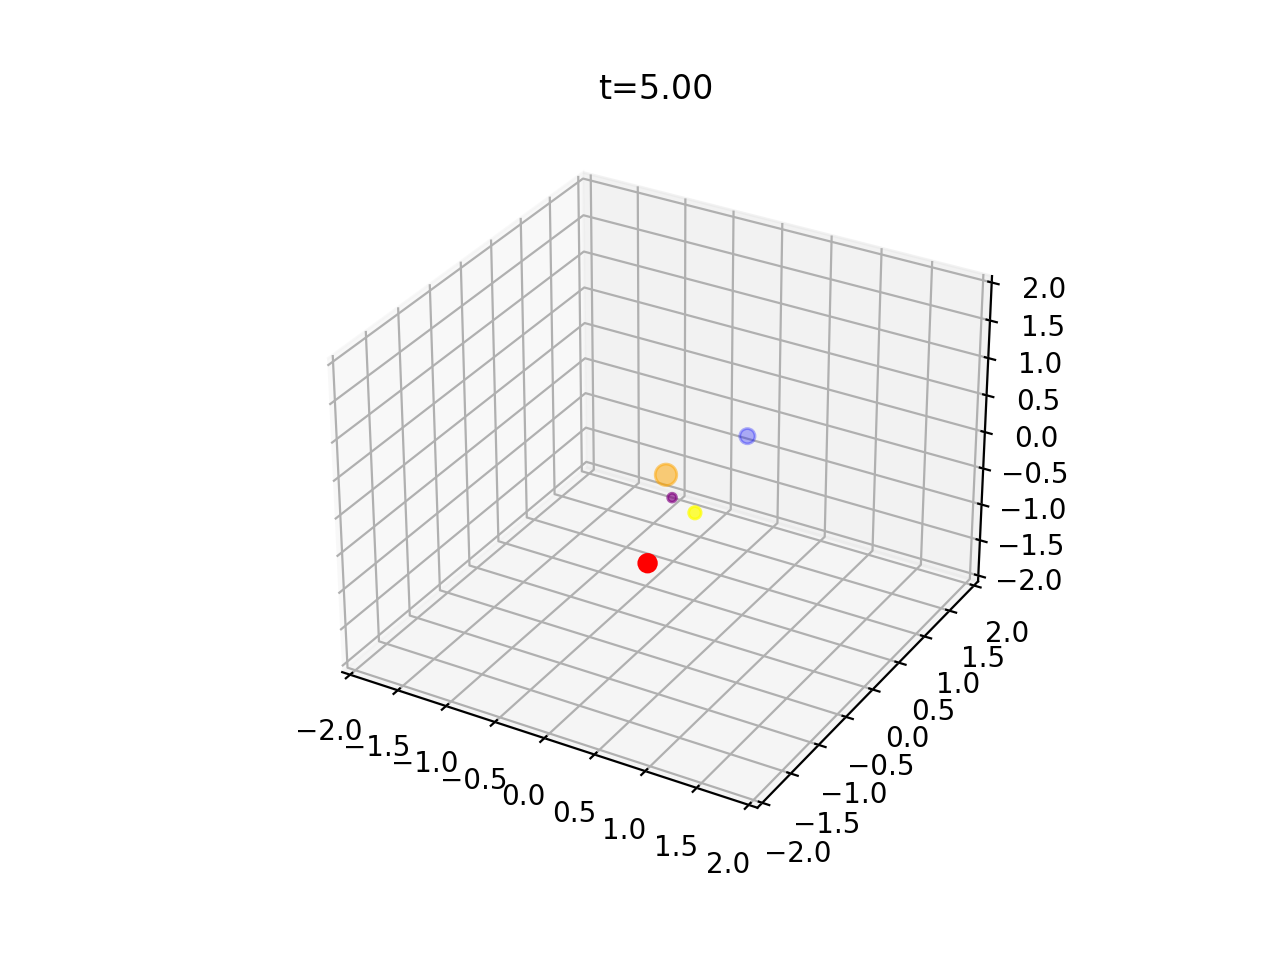

In [2]:
%matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import fmm3dpy as fmm3
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def grav_force(t,y,m):
        n = np.size(m)
        # Extract position and velocity
        ypos = y[0:3*n]
        yvel = y[3*n:]
        
        # Reshape position and prep for fmm call
        ypos = ypos.reshape((n,3)).transpose()
        
        # Call the fmm
        eps = 1e-3
        out = fmm3.lfmm3d(eps=eps,sources=ypos,charges=m,pg=2)
        forces = out.grad.transpose().reshape(3*n)
        
        # reassmeble the forces
        yout = np.concatenate((yvel,forces))
        return yout

# Masses of sun, and the first four planets so that the mass of the sun is 1
m = np.array((1,1/6023600,1/408524,1/332946.038,1/3098710))

# radii of the planets so that the earth is a unit distance away from the sun
r = np.array(([0,0,0],[0.4,0,0],[0,0.7,0],[1,0,0],[0,1.5,0]))

# velocity is r^{\perp} but in plane
v = np.array(([0,0,0],[0,-np.sqrt(1/0.4),0],[np.sqrt(1/0.7),0,0],[0,-1.0,0],[np.sqrt(1.0/1.5),0,0]))


nextra = 0
mextra = np.random.uniform(0,1e-8,nextra)
m = np.concatenate((m,mextra))

rbd = nextra**(1/3)
rextra = np.random.uniform(-rbd,rbd,(nextra,3))
r = np.concatenate((r,rextra))


v = np.array(([0,0,0],[0,-np.sqrt(1/0.4),0],[np.sqrt(1/0.7),0,0],[0,-1.0,0],[np.sqrt(1.0/1.5),0,0]))
vextra = np.random.uniform(-1,1,(nextra,3))
v = np.concatenate((v,vextra))

sizevals = [60,10,20,30,40]
plotcolors = ['orange','purple','yellow','blue','red']
[plotcolors.append('black') for i in range(nextra)]
[sizevals.append(10) for i in range(nextra)]


n = np.size(m)
r0 = r.reshape(3*n)
v0 = v.reshape(3*n)
yinit = np.concatenate((r0,v0))
t_span = (0,5)

nframes = 20
t_eval = np.linspace(t_span[0],t_span[1],nframes)

sol = solve_ivp(grav_force,t_span,yinit,t_eval=t_eval,args=(m,),max_step=0.05)

def init():
    y = yinit
    ypos = y[0:3*n]
    ypos = ypos.reshape((n,3)).transpose()
    ax.scatter(ypos[0,:],ypos[1,:],ypos[2,:])
    
def run(i):
    ax.clear()
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)
    y = sol.y[:,i]
    ypos = y[0:3*n]
    ypos = ypos.reshape((n,3)).transpose()
    ax.scatter(ypos[0,:],ypos[1,:],ypos[2,:],s=sizevals,c=plotcolors)
    plt.title('t='+f'{sol.t[i]:.2f}')

fig=plt.figure()
ax = plt.subplot(projection='3d')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

nfuse = np.max((nframes,np.size(sol.t)))
ani = animation.FuncAnimation(fig, run, frames=nframes, interval=30, init_func=init,repeat=False)
plt.show()